<center><img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Jigsaw%20Multilingual%20Toxic%20Comment%20Classification/banner.png'></center>

<br>
<center><h1>Jigsaw Multilingual Toxic Comment Classification</h1></center>

<br>
<center><h3>Jigsaw - TPU optimized training loops</h3></center>

<br>
<br>
**This notebooks implements Martin Gorner's suggestions to improve training time from the [Flower Classification with TPUs](https://www.kaggle.com/c/flower-classification-with-tpus) competition, here I'll show how to incorporate the optimizations on the Jigsaw competition and I've also implemented early stopping and model checkpointing, [here is](https://www.kaggle.com/dimitreoliveira/flower-with-tpus-k-fold-optimized-training-loops) one way you could use it with K-fold. From the [reference notebook](https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu):**

#### Optimizations:
- use `dataset.batch(BATCH_SIZE, drop_remainder=True)` The training dataset is infinitely repeated so drop_remainder=True should not be needed. However, whith the setting, Tensorflow produces batches of a known size and although XLA (the TPU compiler) can now handle variable batches, it is slightly faster on fixed batches. On the validation dataset, this setting can drop some validation images. It is not the case here because the validation dataset happens to contain an integral number of batches.

#### Optimizations specific to the TPU-optimized custom training loop:
- The training and validation step functions run multiple batches at once. This is achieved by placing a loop using `tf.range()` in the step function. The loop will be compiled to (thanks to ` @tf.function`) and executed on TPU.
- The validation dataset is made to repeat indefinitely because handling end-of-dataset exception in a TPU loop implemented with `tf.range()` is not yet possible. Validation is adjusted to always use exactly or more than the entire validation dataset. This could change numerics. It happens that in this example, the validation dataset is used exactly once per validation.
- The validation dataset iterator is not reset between validation runs. Since the iterator is passed into the step function which is then compiled for TPU (thanks to ` @tf.function`), passing a fresh iterator for every validation run would trigger a fresh recompilation. With a validation at the end of every epoch this would be slow.
- Losses are reported through Keras metrics. It is possible to return values from step function and return losses in that way. However, in the optimized version of the custom training loop, using `tf.range()`, aggregating losses returned from multiple batches becomes impractical.

## Dependencies

In [1]:
import os, gc, time, warnings, transformers
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tokenizers import BertWordPieceTokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, roc_auc_score,classification_report

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, 18))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_confusion_matrix(y_train, train_pred, y_valid, valid_pred, labels=[0, 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    train_cnf_matrix = confusion_matrix(y_train, train_pred)
    validation_cnf_matrix = confusion_matrix(y_valid, valid_pred)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

# Datasets
def get_training_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_training_dataset_evaluate():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(repeated=False):
    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset():
    dataset = tf.data.Dataset.from_tensor_slices(x_test)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

## TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
train = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv", 
                    usecols=['id', 'comment_text', 'toxic'])
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', 
                    usecols=['id', 'comment_text', 'toxic'])
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv', 
                   usecols=['id', 'content'])

print('Jigsaw toxic comment samples %d' % len(train))
display(train.head())

Jigsaw toxic comment samples 223549


,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


# Model parameters

In [5]:
MAX_LEN = 512
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5 # * strategy.num_replicas_in_sync
ES_PATIENCE = 6

base_model_name = 'distilbert-base-multilingual-cased'
model_path = 'model.h5'
vocab_path = '/kaggle/working'

## Tokenizer

In [6]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(base_model_name)
tokenizer.save_pretrained(vocab_path)

tokenizer = BertWordPieceTokenizer(vocab_path + '/vocab.txt', lowercase=False)
tokenizer.enable_truncation(max_length=MAX_LEN)
tokenizer.enable_padding(max_length=MAX_LEN)

## Build TF datasets

In [7]:
x_train = [x.ids for x in tokenizer.encode_batch(train['comment_text'].apply(lambda x : x).tolist())]
x_valid = [x.ids for x in tokenizer.encode_batch(valid['comment_text'].apply(lambda x : x).tolist())]
x_test = [x.ids for x in tokenizer.encode_batch(test['content'].apply(lambda x : x).tolist())]

#  Labels needs to be reshaped
y_train = train['toxic'].values.reshape(len(x_train), 1)
y_valid = valid['toxic'].values.reshape(len(x_valid), 1)

AUTO = tf.data.experimental.AUTOTUNE

# distribute the datset according to the strategy
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset())
# Hitting End Of Dataset exceptions is a problem in this setup. Using a repeated validation set instead.
# This will introduce a slight inaccuracy because the validation dataset now has some repeated elements.
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(repeated=True))

train_data_iter = iter(train_dist_ds) # the training data iterator is repeated and it is not reset
                                      # for each validation run (same as model.fit)
valid_data_iter = iter(valid_dist_ds) # the validation data iterator is repeated and it is not reset
                                      # for each validation run (different from model.fit whre the  
                                      # recommendation is to use a non-repeating validation dataset)

STEPS_PER_TPU_CALL = len(train) // BATCH_SIZE
VALIDATION_STEPS_PER_TPU_CALL = len(valid) // BATCH_SIZE

# Learning rate schedule

Learning rate schedule: 1e-09 to 1e-05 to 1.4e-06


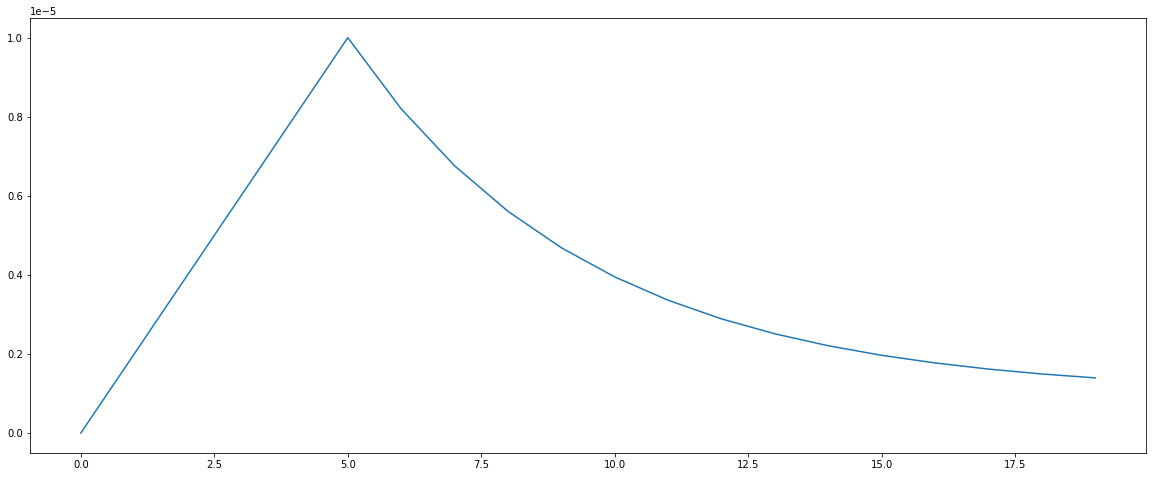

In [8]:
LR_START = 1e-9
LR_MIN = 1e-6
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
def model_fn():
    base_model = transformers.TFDistilBertModel.from_pretrained(base_model_name)
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    attention_mask = tf.math.not_equal(input_word_ids, 0)
    
    sequence_output = base_model([input_word_ids, attention_mask])[0]
    
#     x = GlobalAveragePooling1D()(sequence_output)
    x = GlobalAveragePooling1D()(sequence_output, mask=attention_mask)
    x = Dropout(0.25)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=['accuracy', metrics.AUC()])
    
    return model

### Step functions

In [10]:
@tf.function
def train_step(data_iter):
    def train_step_fn(images, labels):
        with tf.GradientTape() as tape:
            probabilities = model(images, training=True)
            loss = loss_fn(labels, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_accuracy.update_state(labels, probabilities)
        train_auc.update_state(labels, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(STEPS_PER_TPU_CALL):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(images, labels):
        probabilities = model(images, training=False)
        loss = loss_fn(labels, probabilities)
        valid_accuracy.update_state(labels, probabilities)
        valid_auc.update_state(labels, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(VALIDATION_STEPS_PER_TPU_CALL):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

In [11]:
with strategy.scope():
    model = model_fn()

    # Instiate optimizer with learning rate schedule
    class LRSchedule(optimizers.schedules.LearningRateSchedule):
        def __call__(self, step):
            return lrfn(epoch=step//STEPS_PER_TPU_CALL)
    optimizer = optimizers.Adam(learning_rate=LRSchedule())

    train_accuracy = metrics.BinaryAccuracy()
    train_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_accuracy = metrics.BinaryAccuracy()
    valid_auc = metrics.AUC()
    valid_loss = metrics.Sum()

    loss_fn = losses.binary_crossentropy

# Optimized training loop

In [12]:
step = 0
epoch = 0
epoch_steps = 0
epoch_start_time = time.time()
history = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': [], 
           'accuracy': [], 'val_accuracy': []}
patience_cnt = 0
best_val = float("inf")

### Train model
while True:
    # run training step
    train_step(train_data_iter)
    epoch_steps += STEPS_PER_TPU_CALL
    step += STEPS_PER_TPU_CALL

    # validation run at the end of each epoch
    if (step // STEPS_PER_TPU_CALL) > epoch:
        # validation run
        valid_epoch_steps = 0
        valid_step(valid_data_iter)
        valid_epoch_steps += VALIDATION_STEPS_PER_TPU_CALL

        # compute metrics
        history['accuracy'].append(train_accuracy.result().numpy())
        history['auc'].append(train_auc.result().numpy())
        history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
        history['val_accuracy'].append(valid_accuracy.result().numpy())
        history['val_auc'].append(valid_auc.result().numpy())
        history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))

        # report metrics
        epoch_time = time.time() - epoch_start_time
        print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
        print('time: {:0.1f}s'.format(epoch_time),
              'loss: {:0.4f}'.format(history['loss'][-1]),
              'auc: {:0.4f}'.format(history['auc'][-1]),
              'accuracy: {:0.4f}'.format(history['accuracy'][-1]),
              'val_loss: {:0.4f}'.format(history['val_loss'][-1]),
              'val_auc: {:0.4f}'.format(history['val_auc'][-1]),
              'val_accuracy: {:0.4f}'.format(history['val_accuracy'][-1])
             )
        print('LearningRate: {:0.4g}'.format(lrfn(epoch)))

        # set up next epoch
        epoch = step // STEPS_PER_TPU_CALL
        epoch_steps = 0
        epoch_start_time = time.time()
        train_accuracy.reset_states()
        train_auc.reset_states()
        train_loss.reset_states()
        valid_accuracy.reset_states()
        valid_auc.reset_states()
        valid_loss.reset_states()
        if epoch >= EPOCHS:
            model.save_weights(model_path)
            break

        # Early stopping monitor
        if history['val_loss'][-1] <= best_val:
            best_val = history['val_loss'][-1]
            model.save_weights(model_path)
            print('Saved model weights at "%s"' % model_path)
        else:
            patience_cnt += 1
        if patience_cnt > ES_PATIENCE:
            print('Epoch %05d: early stopping' % epoch)
            break


EPOCH 1/20
time: 302.5s loss: 0.9100 auc: 0.5547 accuracy: 0.1509 val_loss: 0.7494 val_auc: 0.5144 val_accuracy: 0.3228
LearningRate: 1e-09
Saved model weights at "model.h5"

EPOCH 2/20
time: 246.3s loss: 0.2695 auc: 0.8011 accuracy: 0.8956 val_loss: 0.3850 val_auc: 0.7311 val_accuracy: 0.8478
LearningRate: 2.001e-06
Saved model weights at "model.h5"

EPOCH 3/20
time: 246.7s loss: 0.1489 auc: 0.9499 accuracy: 0.9401 val_loss: 0.4211 val_auc: 0.7912 val_accuracy: 0.8477
LearningRate: 4.001e-06

EPOCH 4/20
time: 244.3s loss: 0.1093 auc: 0.9737 accuracy: 0.9555 val_loss: 0.4752 val_auc: 0.8106 val_accuracy: 0.8483
LearningRate: 6e-06

EPOCH 5/20
time: 244.2s loss: 0.0967 auc: 0.9800 accuracy: 0.9610 val_loss: 0.5252 val_auc: 0.8130 val_accuracy: 0.8490
LearningRate: 8e-06

EPOCH 6/20
time: 244.2s loss: 0.0867 auc: 0.9839 accuracy: 0.9649 val_loss: 0.6285 val_auc: 0.7940 val_accuracy: 0.8440
LearningRate: 1e-05

EPOCH 7/20
time: 244.3s loss: 0.0778 auc: 0.9873 accuracy: 0.9682 val_loss: 0

## Model loss graph

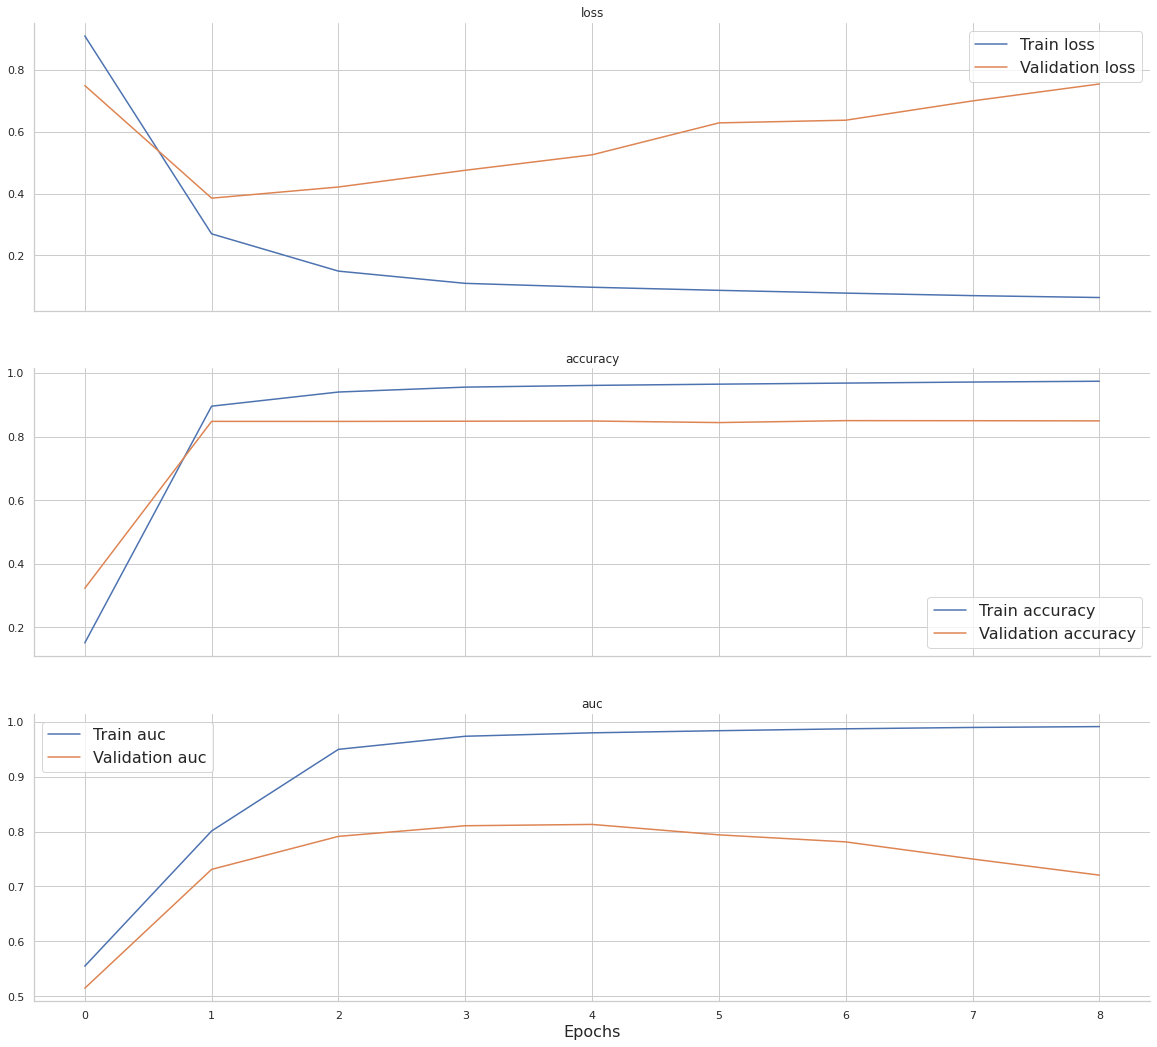

In [13]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'accuracy', 'auc'])

# Model evaluation

In [14]:
model.load_weights(model_path)

train_pred = model.predict(get_training_dataset_evaluate(), steps=STEPS_PER_TPU_CALL)
valid_pred = model.predict(get_validation_dataset())
train = train[:len(train_pred)]
valid = valid[:len(valid_pred)]
train['pred'] = train_pred
valid['pred'] = valid_pred

print('Train set ROC AUC %.4f' % roc_auc_score(train['toxic'], train['pred']))
print(classification_report(train['toxic'],  np.round(train['pred'])))
print('Validation set ROC AUC %.4f' % roc_auc_score(valid['toxic'], valid['pred']))
print(classification_report(valid['toxic'],  np.round(valid['pred'])))

Train set ROC AUC 0.9113
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    201868
           1       0.73      0.33      0.46     21364

    accuracy                           0.92    223232
   macro avg       0.83      0.66      0.71    223232
weighted avg       0.91      0.92      0.91    223232

Validation set ROC AUC 0.7349
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      6494
           1       0.66      0.05      0.10      1186

    accuracy                           0.85      7680
   macro avg       0.76      0.52      0.51      7680
weighted avg       0.82      0.85      0.79      7680



# Confusion matrix

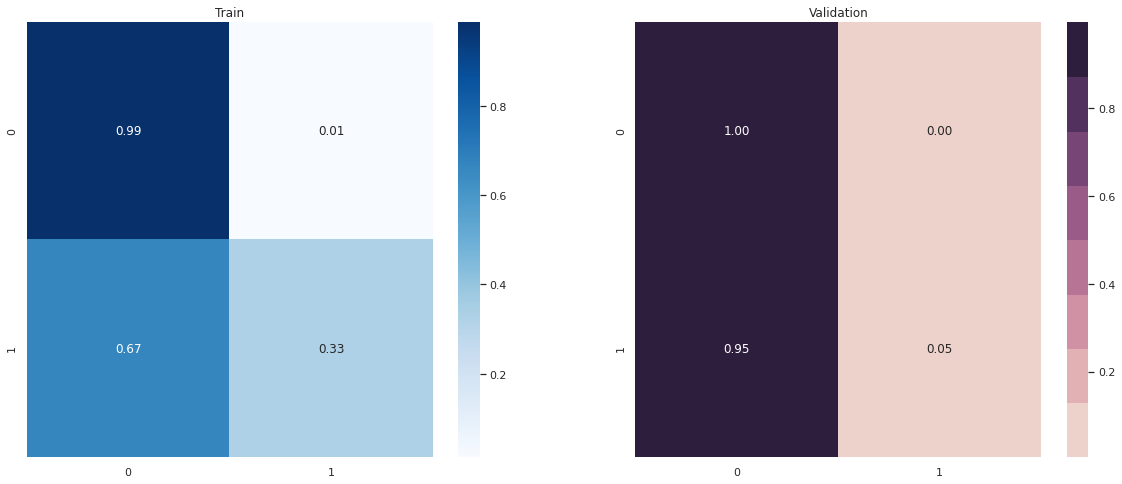

In [15]:
plot_confusion_matrix(train['toxic'], np.round(train['pred']), 
                      valid['toxic'], np.round(valid['pred']))

# Visualize predictions

In [16]:
print('Train set')
display(train[['comment_text', 'toxic', 'pred']].head(10))
print('Validation set')
display(valid[['comment_text', 'toxic', 'pred']].head(10))

Train set


,comment_text,toxic,pred
0,Explanation\nWhy the edits made under my usern...,0,0.025700
1,D'aww! He matches this background colour I'm s...,0,0.034077
2,"Hey man, I'm really not trying to edit war. It...",0,0.030149
3,"""\nMore\nI can't make any real suggestions on ...",0,0.005784
4,"You, sir, are my hero. Any chance you remember...",0,0.252145
5,"""\n\nCongratulations from me as well, use the ...",0,0.029485
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0.739506
7,Your vandalism to the Matt Shirvington article...,0,0.032632
8,Sorry if the word 'nonsense' was offensive to ...,0,0.044923
9,alignment on this subject and which are contra...,0,0.017765


Validation set


,comment_text,toxic,pred
0,Este usuario ni siquiera llega al rango de ...,0,0.077867
1,Il testo di questa voce pare esser scopiazzato...,0,0.054318
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,1,0.041959
3,Bu maddenin alt başlığı olarak uluslararası i...,0,0.169041
4,Belçika nın şehirlerinin yanında ilçe ve belde...,0,0.213199
5,"güzel, zaten kaynaklandırması zor subjektif ka...",0,0.194172
6,"No es mala idea. De hecho, yo estaba pensando ...",0,0.048583
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık ç...",0,0.165205
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umar...,0,0.181794
9,Creo que es importante que podamos reconocer a...,0,0.043767


# Test set predictions

In [17]:
Y_test = model.predict(get_test_dataset())
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = Y_test
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,toxic
0,0,0.176249
1,1,0.041614
2,2,0.195476
3,3,0.158103
4,4,0.077825
5,5,0.255970
6,6,0.061944
7,7,0.201513
8,8,0.074703
9,9,0.502393
